## Question 5: Extra Credit (15 points)

For extra credit, we will implement a smarter form of image blending, where seams are minimized. This can be used to handle exposure differences between stitches images, correct for motion blur, and even act as a photoshop healing tool. For examples in photo stitching, see [this link](http://www.cs.jhu.edu/~misha/Code/SMG/) or [this link](http://www.cs.jhu.edu/~misha/Code/DMG/Version4.5/).

### 5.1 (15 points)

In this section we will implement __Poisson Image Stitching__ \[perez2003poisson\] which can be used to create seamless photo montages. 

|<img align="center" src="figure/poisson_stitching.png" width="500">|
|:--:|
|Fig 5.1 Example of Possion image stitching.|

Write a function called $\texttt{poisson_blend(background,foreground,mask)}$ which takes 3 equal sized images (background and foreground as RGB, mask as binary) and solves the Poisson equation, using gradients from foreground and boundary conditions from the background. 

**The problem will be manually graded.** Please include results from the $\texttt{(fg1,bg1,mask1)}$ images in your write-up.

*Hint:* The basic idea behind Poisson Image Stitching is to setup a linear system $A x = b$ where each row of $A$ is the gradient operator for the image pixel mask (e.g. 4 for each pixel, and -1 +1 for it's 4 neighbors), while the row in $b$ contains known gradients from the foreground. Additional rows in $A$ are pixels on the boundary, which have known values, stored in $b$. Solving for $x$ then gives you pixel values for the entire masked patch. This is done for each image channel seperately. See [this page](http://www.ctralie.com/Teaching/PoissonImageEditing/) or [this page](http://cs.brown.edu/courses/csci1950-g/results/proj2/pdoran/index.html) if you need more information. 

Background:  (300, 450, 3)
Foreground:  (300, 450, 3)
Mask:  (300, 450)
Made sparse matrix
Set identity areas


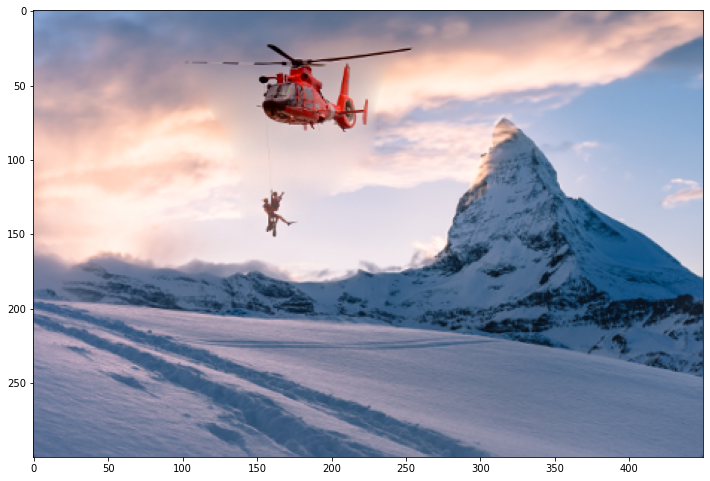

Background:  (450, 800, 3)
Foreground:  (450, 800, 3)
Mask:  (450, 800)
Made sparse matrix
Set identity areas


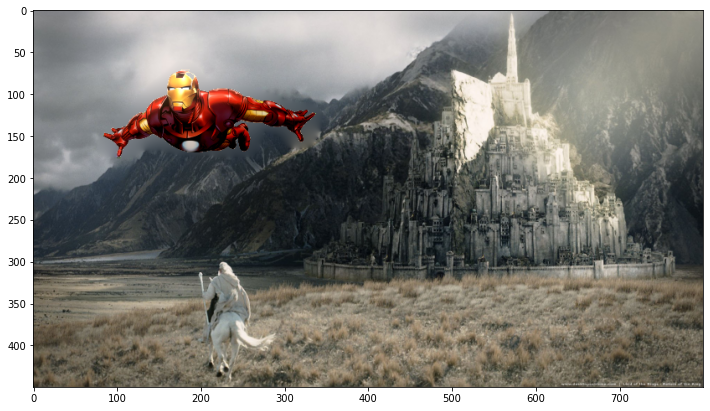

Background:  (768, 1024, 3)
Foreground:  (768, 1024, 3)
Mask:  (768, 1024)
Made sparse matrix
Set identity areas


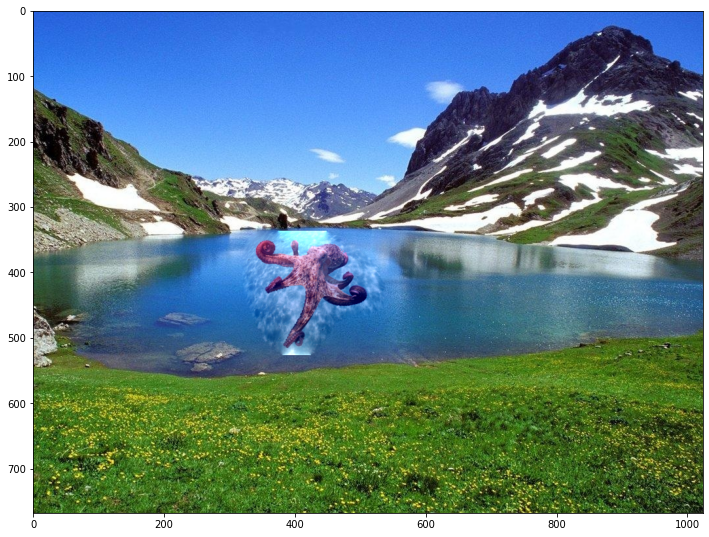

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot
import scipy.sparse
import scipy.sparse.linalg


def float_image(path):
    """Opens an image as a 0-1 RGB."""
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB).astype(float) / 255


def mask_image(path):
    """Opens an image as a boolean."""
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE) > 100


def poisson_matrix(N, M):
    """Two-dimensional rectangular grid Poisson equation
    
    Defined here, you can see the D matrix (m, m) and the -I matrices
    on either side of the diagonal. The -I matrices can be created using
    just a properly placed line of 1's
    https://en.wikipedia.org/wiki/Discrete_Poisson_equation
    """
    # Found these sparse matrix tools, playing around with them. Definitely
    # speeds up computation

    # Create the D building block
    D = scipy.sparse.lil_matrix((M, M))
    D.setdiag(-1, 1)
    D.setdiag(4)
    D.setdiag(-1, -1)
    # Tile D onto all the diagonal elements
    A = scipy.sparse.block_diag([D] * N).tolil()
    # Then create the offset -I terms all along the matrix
    A.setdiag(-1, 1 * M)
    A.setdiag(-1, -1 * M)
    return A


def poisson_blend(background, foreground, mask):
    """
    Inspired from these sources
    http://www.ctralie.com/Teaching/PoissonImageEditing/
    https://github.com/Erkaman/poisson_blend/
    https://github.com/PPPW/poisson-image-editing/

    Arguments:
        background: (N, M, 3) RGB image of floats, 0-1
        foreground: (N, M, 3) RGB image of floats, 0-1
        mask: (N, M) image of boolean values
    
    Returns: (N, M, 3) RGB image of floats, 0-1
    """
    N, M = background.shape[:2]
    A = poisson_matrix(N, M)
    print("Made sparse matrix")
    # Compress the matrix down
    laplacian = A.tocsc()
    # Remove the Laplacian [-1, ..., -1, 4, -1, ... -1] components when we
    # are NOT in the marked mask region, setting that part of the equation to
    # just identity
    for ax0 in range(1, N - 1):
        for ax1 in range(1, M - 1):
            if not mask[ax0, ax1]:
                k = ax1 + ax0 * M
                A[k, k] = 1
                for ax1_offset in [-M, -1, 1, M]:
                    A[k, k + ax1_offset] = 0
    print("Set identity areas")
    # Compress the matrix again
    A = A.tocsc()

    notmask_flat = np.logical_not(mask.flatten())
    blended = []
    for channel in range(background.shape[2]):
        bg_channel = background[:, :, channel].flatten()
        fg_channel = foreground[:, :, channel].flatten()
        # Set the b vector (the thing we want to approximate with Ax) to the foreground gradient
        b_vector = laplacian.dot(fg_channel)
        # Everywhere the mask is false, just use the background gradient
        b_vector[notmask_flat] = bg_channel[notmask_flat]
        # Solve, unflatten, scale, clip, and cast
        x_vector = scipy.sparse.linalg.spsolve(A, b_vector)
        x_vector = x_vector.reshape((N, M))
        x_vector = np.clip(x_vector * 255, 0, 255).astype(np.uint8)
        # Stack the answers by channel
        blended.append(x_vector)
    blended = np.dstack(blended)

    return blended


paths = (
    ("data/bg1.png", "data/fg1.png", "data/mask1.png"),
    ("data/poisson_background.png", "data/poisson_foreground.png", "data/poisson_mask.png"),
    ("data/poisson_background_2.jpg", "data/poisson_foreground_2.png", "data/poisson_mask_2.png"),
)
for bg_path, fg_path, mask_path in paths:
    bg = float_image(bg_path)
    fg = float_image(fg_path)
    mask = mask_image(mask_path)
    print("Background: ", bg.shape)
    print("Foreground: ", fg.shape)
    print("Mask: ", mask.shape)
    blended = poisson_blend(bg, fg, mask)

    # pyplot.imshow(bg); pyplot.show()
    # pyplot.imshow(fg); pyplot.show()
    # pyplot.imshow(mask); pyplot.show()

    figure = pyplot.figure(figsize=(12, 12))
    pyplot.imshow(blended)
    pyplot.show()